In [1]:
# ! pip install --quiet gensim

In [2]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

yelps = pd.read_csv('sentiment/yelps.csv').sample(frac=0.5)

In [3]:
from bs4 import BeautifulSoup
import re
from nltk.tokenize import word_tokenize 

def clean_yelp(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """
    
    token_pattern=r"(?u)\b\w\w+\b"
    token_pattern = re.compile(token_pattern)
    return token_pattern.findall(s)
    
#     s = word_tokenize(s) # easier to use nltk word_tokenizer, which is a bunch of regular expressions
#                          # https://www.nltk.org/_modules/nltk/tokenize.html
    
    return s 

    # Implement this function!
    # Hint: If you look at the sklearn source code on github, 
    # you will find a good regular expression they use as a default
    # tokenizer in CountVectorizer -- this is the tokenizer
    # we have been using until now!
    # But you need to implement your own now. 

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

# Create a count vectorizer, using the preprocessor and tokenizer from above
vectorizer_yelp = CountVectorizer(preprocessor=clean_yelp,tokenizer=tokenize)
# use TruncatedSVD from Sklearn to generate a term embedding matrix for your data
# that is 100 dimensional in size.
TF_yelp         = vectorizer_yelp.fit_transform(yelps.text)
# Embed your documents via that term embedding matrix (this is just the PCA of the 
# TF matrix, as returned by "transform" on TruncatedSVD
trun            = TruncatedSVD(n_components=100)
PCA_yelp        = trun.fit_transform(TF_yelp)

# Here you should have TWO vector representations of your Yelp data: 
# 1. The original TF matrix
# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression()
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

In [6]:
# Test your vector representations using the above function, test_holdout_vectors. 
# for several levels of "cutoff".

cutoff = []
for cut in np.arange(0.05, 0.5, 0.025):
    cutoff.append(int(len(yelps.positive)*cut))

accuracy_TF_yelp  = [test_holdout_vectors(TF_yelp, yelps.positive, c) 
             for c in cutoff]

accuracy_PCA_yelp = [test_holdout_vectors(PCA_yelp, yelps.positive, c) 
             for c in cutoff]
# truncated = [test_holdout_vectors(PCA_yelp, yelps.positive, c) for c in cuts]
# This function simulates training on a small part of your data and testing on the rest.
# Thus, it's as though you have some labelled data but a bunch of unlabelled data. 
# This is essentially a semi-supervised situation. 

# Do the word embeddings generated via SVD allow you to pull information from the 
# unlabeled data and improve your score given a small training set? 

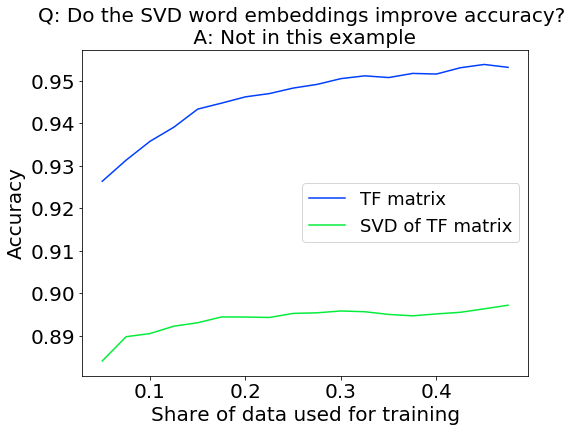

In [31]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')

plt.figure(figsize=(8,6))
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_TF_yelp)
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_PCA_yelp)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.legend(['TF matrix','SVD of TF matrix'],fontsize=18)
plt.xlabel('Share of data used for training',fontsize=20)
plt.title('Q: Do the SVD word embeddings improve accuracy? \n A: Not in this example ',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.show()

**Understanding some of the Word2Vec  hyperparameters**

**size:**
The size of the dense vector to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, it's good to experiment with various sizes. 

**window:**
The maximum distance between the target word and its neighboring word. If your neighbor's position is greater than the maximum window width to the left and the right, then, some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its a decent sized window.

**min_count:**
Minimium frequency count of words. The model would ignore words that do not satisfy the min_count. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.

**workers:**
How many threads to use behind the scenes?

In [9]:
from gensim.models import Word2Vec
import multiprocessing
cores = multiprocessing.cpu_count()

# Next, create another term embedding via Word2Vec, also 100 dimensional
# Look at the documentation from the library gensim and see what hyperparameters
# you can choose to tune. 
# Note: training takes time, so you probably won't want to try too many!
sentences = yelps.text.apply(clean_yelp).apply(tokenize)
model     = Word2Vec(sentences, window=5, min_count=5, workers=cores-1)
# pass the cleaned and tokenized yelp reviews as "sentences" to your model
# to build the vocabulary and train the word vectors. 

In [10]:
# test 
w1 = "amazing"
model.wv.most_similar (positive=w1,topn=5)

[('awesome', 0.9085025787353516),
 ('incredible', 0.9066208600997925),
 ('fantastic', 0.8942044973373413),
 ('fabulous', 0.8520108461380005),
 ('excellent', 0.829370379447937)]

In [11]:
import numpy as np

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0) #fixed to add summation
    a /= np.linalg.norm(a)
    return a

# use as follows: np.array([embed_w2v(t, w2v) for t in X])

In [12]:
# use the embed_w2v function to embed your Yelp reviews using the new
# word2vec word embeddings. Each review will be a normalized sum of the
# words that it is made of. 
# See how this improves the scores in the classification task using
# test_holdout_vectors -- is word2vec better? At what training-set sizes does it help
# more? 
w2v_matrix    = np.array([embed_w2v(t, model) for t in sentences])
accuracy_w2v = [test_holdout_vectors(w2v_matrix, yelps.positive, c) for c in cutoff]

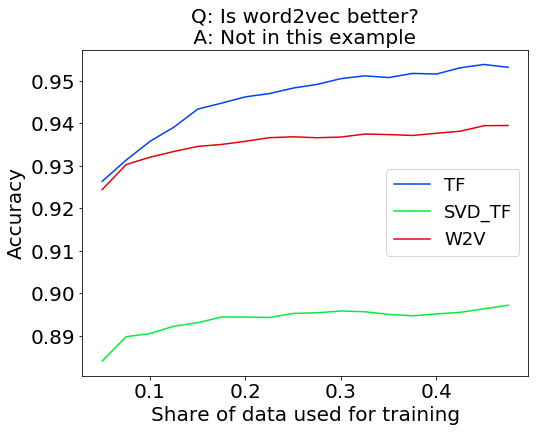

In [13]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_TF_yelp)
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_PCA_yelp)
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_w2v)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.legend(['TF','SVD_TF','W2V'],fontsize=18)
plt.xlabel('Share of data used for training',fontsize=20)
plt.title('Q: Is word2vec better?\n A: Not in this example ',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.show()

In [14]:
import pandas as pd
import re
from functools import reduce

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    
    # remove twitter handles (@user); URLs; RT; and random punctuation
    s = re.sub(r"([@#&]\w+)|https\S+|RT|:|;|\n|@", '', s)
    
    # keep only words
    s = re.sub("[^a-zA-Z]", " ", s)
    
    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!

    # BONUS: Try using the library "spacy" to 
    # do further processing, such as lemmatizing
    # or replacing Named Entities with constants (i.e. "[NAMED]")
    # or adding the part of speech or dependency code to the word 

    return s

In [15]:
# Load tweet!
# NOTE: this file needs to be downloaded from Box! 

with open('tweets/tweets.txt') as f:
    tweets = pd.Series(f.readlines())

In [16]:
# Now embed this twitter data, again using Word2Vec and LSA (SVD)
# you don't have any labels, but you might be able to 
# find some interesting phenomena. 
vectorizer_yelp = CountVectorizer(preprocessor=clean_twitter)
TF_tweets       = vectorizer_yelp.fit_transform(tweets)

trun2      = TruncatedSVD(n_components=100)
PCA_tweets = trun2.fit_transform(TF_tweets)

# Bonus: build a similar feature for your LSA features and
# see if you can do similar vector math

In [17]:
#prepare word2vec 'sentences'
sentences2  = [clean_twitter(t).split(' ') for t in tweets]
model_tweet = Word2Vec(sentences2, window=5, min_count=2, workers=cores-1)
# model.train(sentences2,total_examples=len(sentences2),epochs=10)

In [18]:
#embeddings
w2v_tweets  = np.array([embed_w2v(t, model_tweet) for t in sentences2])

In [19]:
# Explore using either or both of the following tools: 
# 1. Word2Vec has a built in feature for getting most similar
# words, including via positive/negative examples (subtraction)
# What happens when you subtract "hillary" from "trump"? 
print("'trump' is found in this context:")
print(model_tweet.wv.most_similar (positive="trump",topn=2))
print()
print("'hillary' is found in this context:")
print(model_tweet.wv.most_similar (positive="hillary",topn=2))
print()
print("'which word is to democrat as hillary is to trump:")
print(model_tweet.wv.most_similar(positive=["democrat", "hillary"], negative=["trump"],topn=2))

'trump' is found in this context:
[('Trump', 0.6879494190216064), ('Bernie', 0.6332614421844482)]

'hillary' is found in this context:
[('Hilliary', 0.6007615327835083), ('Hilary', 0.5974376201629639)]

'which word is to democrat as hillary is to trump:
[('congenital', 0.5786762237548828), ('rotten', 0.5733319520950317)]


In [20]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]))

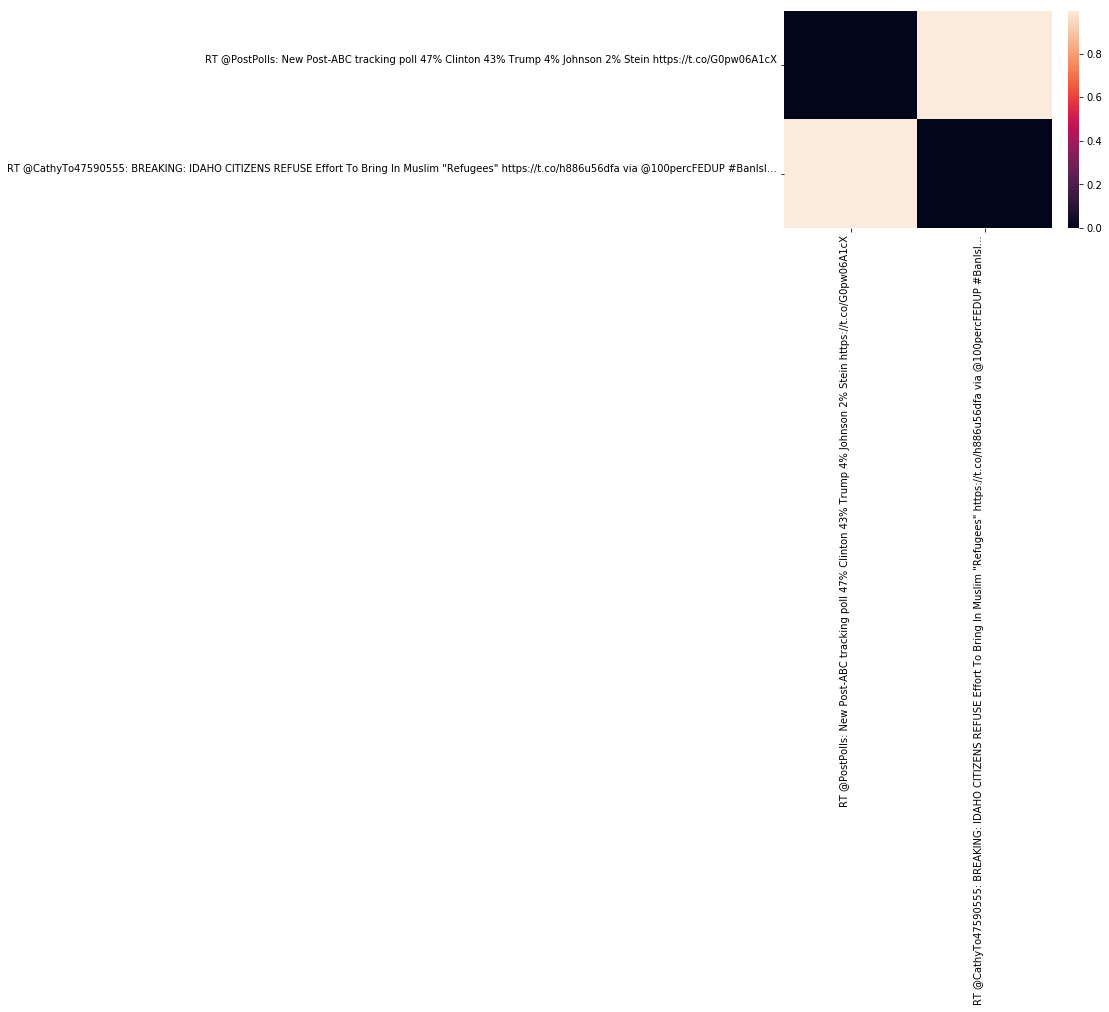

In [21]:
# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another? 
idx = np.random.randint(0, high=len(tweets), size=2)
visualize_dist(PCA_tweets, tweets, idx)

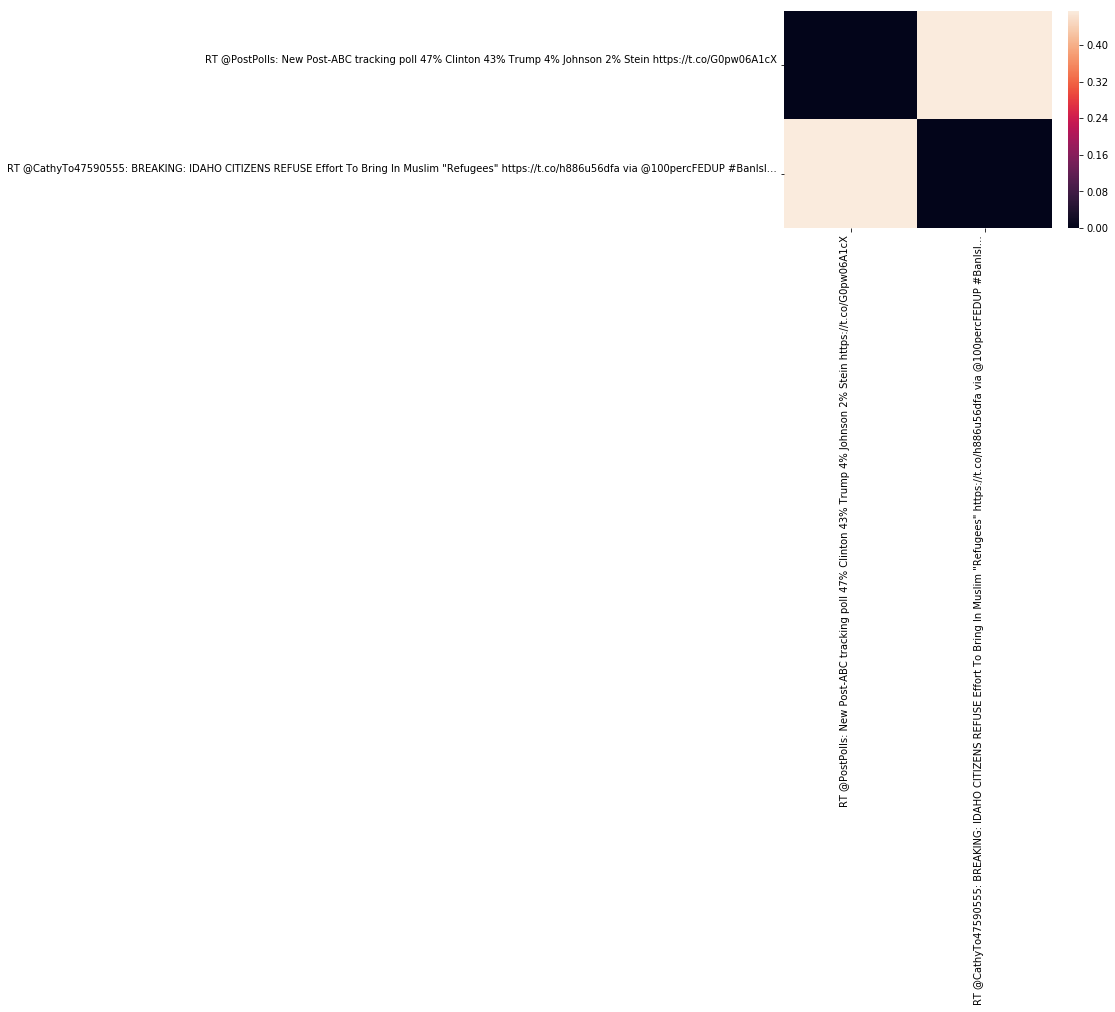

In [22]:
visualize_dist(w2v_tweets, tweets, idx)

In [23]:
# More bonus!
# Use one of the following pre-embedded models and see if your yelp scores improve? 
# What about your Twitter explorations?

# https://github.com/RaRe-Technologies/gensim-data

#### The Google News model, which was trained on about 100 billion words.

In [24]:
import gensim.downloader as api
model_google = api.load("word2vec-google-news-300")

In [25]:
# Check dimension of word vectors
model_google.vector_size

300

In [26]:
w2v_matrix_google   = np.array([embed_w2v(t, model_google) for t in sentences])
accuracy_w2v_google = [test_holdout_vectors(w2v_matrix_google, yelps.positive, c) for c in cutoff]

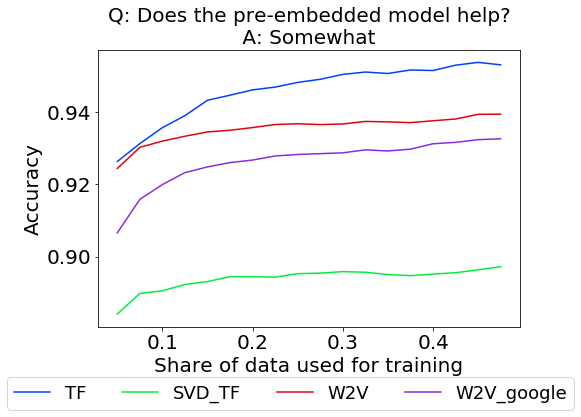

In [45]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_TF_yelp)
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_PCA_yelp)
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_w2v)
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_w2v_google)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.legend(['TF','SVD_TF','W2V','W2V_google'],fontsize=18,bbox_to_anchor=(1.15, -0.15),ncol=4)
plt.xlabel('Share of data used for training',fontsize=20)
plt.title('Q: Does the pre-embedded model help?\n A: Somewhat ',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.tight_layout()
plt.show()